In [1]:
import numpy as np
import scipy.sparse
from loe import LoE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import logging
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
logging.basicConfig(level=logging.INFO)

## Load and prepare the data

In [3]:
df_titanic = pd.read_csv("./data/titanic.csv")
df_titanic.head()

,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked,Age,Survived,name_length
0,3.0,male,1.0,0.0,21171,7.2500,S,22.0,no,23
1,1.0,female,1.0,0.0,17599,71.2833,C,38.0,yes,51
2,3.0,female,0.0,0.0,3101282,7.9250,S,26.0,yes,22
3,1.0,female,1.0,0.0,113803,53.1000,S,35.0,yes,44
4,3.0,male,0.0,0.0,373450,8.0500,S,35.0,no,24


In [4]:
def one_hot_encode(df: pd.DataFrame, columns_to_encode: list[str] | None = None) -> pd.DataFrame:
    if columns_to_encode is None:
        columns_to_encode = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Initialize ColumnTransformer with OneHotEncoder for the specified columns
    encoder = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse_output=False), columns_to_encode)
        ],
        remainder='passthrough'  # This leaves the rest of the columns in their original form
    )

    # Fit and transform the data
    encoded_array = encoder.fit_transform(df)

    # Extracting new feature names
    # For encoded features
    encoded_feature_names = encoder.named_transformers_['cat'].get_feature_names_out(columns_to_encode)
    # For non-transformed features (remainder), we keep their original names
    non_transformed_features = [col for col in df.columns if col not in columns_to_encode]
    # Combine all feature names
    all_feature_names = list(encoded_feature_names) + non_transformed_features

    # Convert the processed array back to a DataFrame
    encoded_df = pd.DataFrame(encoded_array, columns=all_feature_names, index=df.index)

    return encoded_df

In [5]:
X, y = df_titanic.iloc[:, :-2], df_titanic['Survived']

In [6]:
X_encoded = one_hot_encode(X)

In [7]:
X_encoded.head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass,SibSp,Parch,Ticket,Fare,Age
0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,21171.0,7.2500,22.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,17599.0,71.2833,38.0
2,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,3101282.0,7.9250,26.0
3,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,113803.0,53.1000,35.0
4,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,373450.0,8.0500,35.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.9)

In [9]:
print("Test: ", len(X_test), "Train", len(X_train))

Test:  89 Train 800


## Create LoE Model

In [10]:
loe = LoE(
    # which models (`nerds` / `experts`) you want to use? You can mix an match them as desired
    pool_classifiers=[DecisionTreeClassifier(max_depth=2),
                      DecisionTreeClassifier(max_depth=2), 
                      DecisionTreeClassifier(max_depth=2)],
    # speed of change. This will decrease during training
    step_size=2,  
    # how many training cycles
    iterations=20, 
    # how many features for movement in feature space should be used
    # if `auto`, the features will be added until 60% of the information is accumulated
    # will work for tree based models only (or you will have to patch your own feature_importance_ metric, e.g., by using Shaply etc.)
    maximum_selected_features="auto",
    # if you want to do stuff (e.g., creating an anomation you can add a function to here
    # to inspect the model at each iteration
    step_callback=None,
    
    # deterministic behaviour if needed
    random_state=42,
)

In [11]:
loe.fit(X=X_train.to_numpy(), 
        y=y_train.to_numpy(),
        # You can let the eperts `see` another view to your data 
        # if given X will be handed to the GoN algorithm (here, each feature has to be numeric)
        # and X_expert at the same indices at X will be handed over to X_Expert when learning
        # this can be useful if you model handles Categorical values un its own (like HDTree; see readme)
        # X_expert=...
        )

INFO:LoE:Start performance: 0.800

INFO:LoE:Performing round 0
INFO:LoE:Current step size: 2.000
INFO:LoE:Performance: 0.810
INFO:LoE:Performance increase by 0.010
INFO:LoE:Round took 0.022 seconds

INFO:LoE:Performing round 1
INFO:LoE:Current step size: 1.900
INFO:LoE:Performance: 0.805
INFO:LoE:Round took 1.850 seconds

INFO:LoE:Performing round 2
INFO:LoE:Current step size: 1.800
INFO:LoE:Performance: 0.830
INFO:LoE:Performance increase by 0.020
INFO:LoE:Round took 1.459 seconds

INFO:LoE:Performing round 3
INFO:LoE:Current step size: 1.700
INFO:LoE:Performance: 0.830
INFO:LoE:Round took 1.456 seconds

INFO:LoE:Performing round 4
INFO:LoE:Current step size: 1.600
INFO:LoE:Performance: 0.826
INFO:LoE:Round took 1.616 seconds

INFO:LoE:Performing round 5
INFO:LoE:Current step size: 1.500
INFO:LoE:Performance: 0.826
INFO:LoE:Round took 1.355 seconds

INFO:LoE:Performing round 6
INFO:LoE:Current step size: 1.400
INFO:LoE:Performance: 0.826
INFO:LoE:Round took 1.332 seconds

INFO:LoE:Per

## Report some metrics

In [12]:
print("Feature importances")
list(zip(loe.feature_importances_, X_train.columns))

Feature importances


[(0.17339801522613763, 'Sex_female'),
 (0.18603942172859625, 'Sex_male'),
 (0.08075485525781784, 'Embarked_C'),
 (0.007152712877043548, 'Embarked_Q'),
 (0.040030289484866456, 'Embarked_S'),
 (0.1326485558852793, 'Pclass'),
 (0.10244014904276111, 'SibSp'),
 (0.0019759747608746507, 'Parch'),
 (0.027395165063562536, 'Ticket'),
 (0.14150603579295543, 'Fare'),
 (0.10665882488010517, 'Age')]

In [13]:
print("Train Report")
pd.DataFrame(classification_report(y_pred=loe.predict(X=X_train.to_numpy()), y_true=y_train.to_numpy(), output_dict=True))

Train Report


,no,yes,accuracy,macro avg,weighted avg
precision,0.843444,0.806228,0.83,0.824836,0.828884
recall,0.885010,0.744409,0.83,0.814710,0.830000
f1-score,0.863727,0.774086,0.83,0.818907,0.828655
support,487.000000,313.000000,0.83,800.000000,800.000000


In [14]:
print("test Report")
pd.DataFrame(classification_report(y_pred=loe.predict(X=X_test.to_numpy()), y_true=y_test.to_numpy(), output_dict=True))

test Report


,no,yes,accuracy,macro avg,weighted avg
precision,0.880597,0.863636,0.876404,0.872117,0.875452
recall,0.951613,0.703704,0.876404,0.827658,0.876404
f1-score,0.914729,0.775510,0.876404,0.845119,0.872494
support,62.000000,27.000000,0.876404,89.000000,89.000000


## Plot some data

### "Experts"

In [15]:
experts: list[DecisionTreeClassifier] = loe.pool_classifiers_

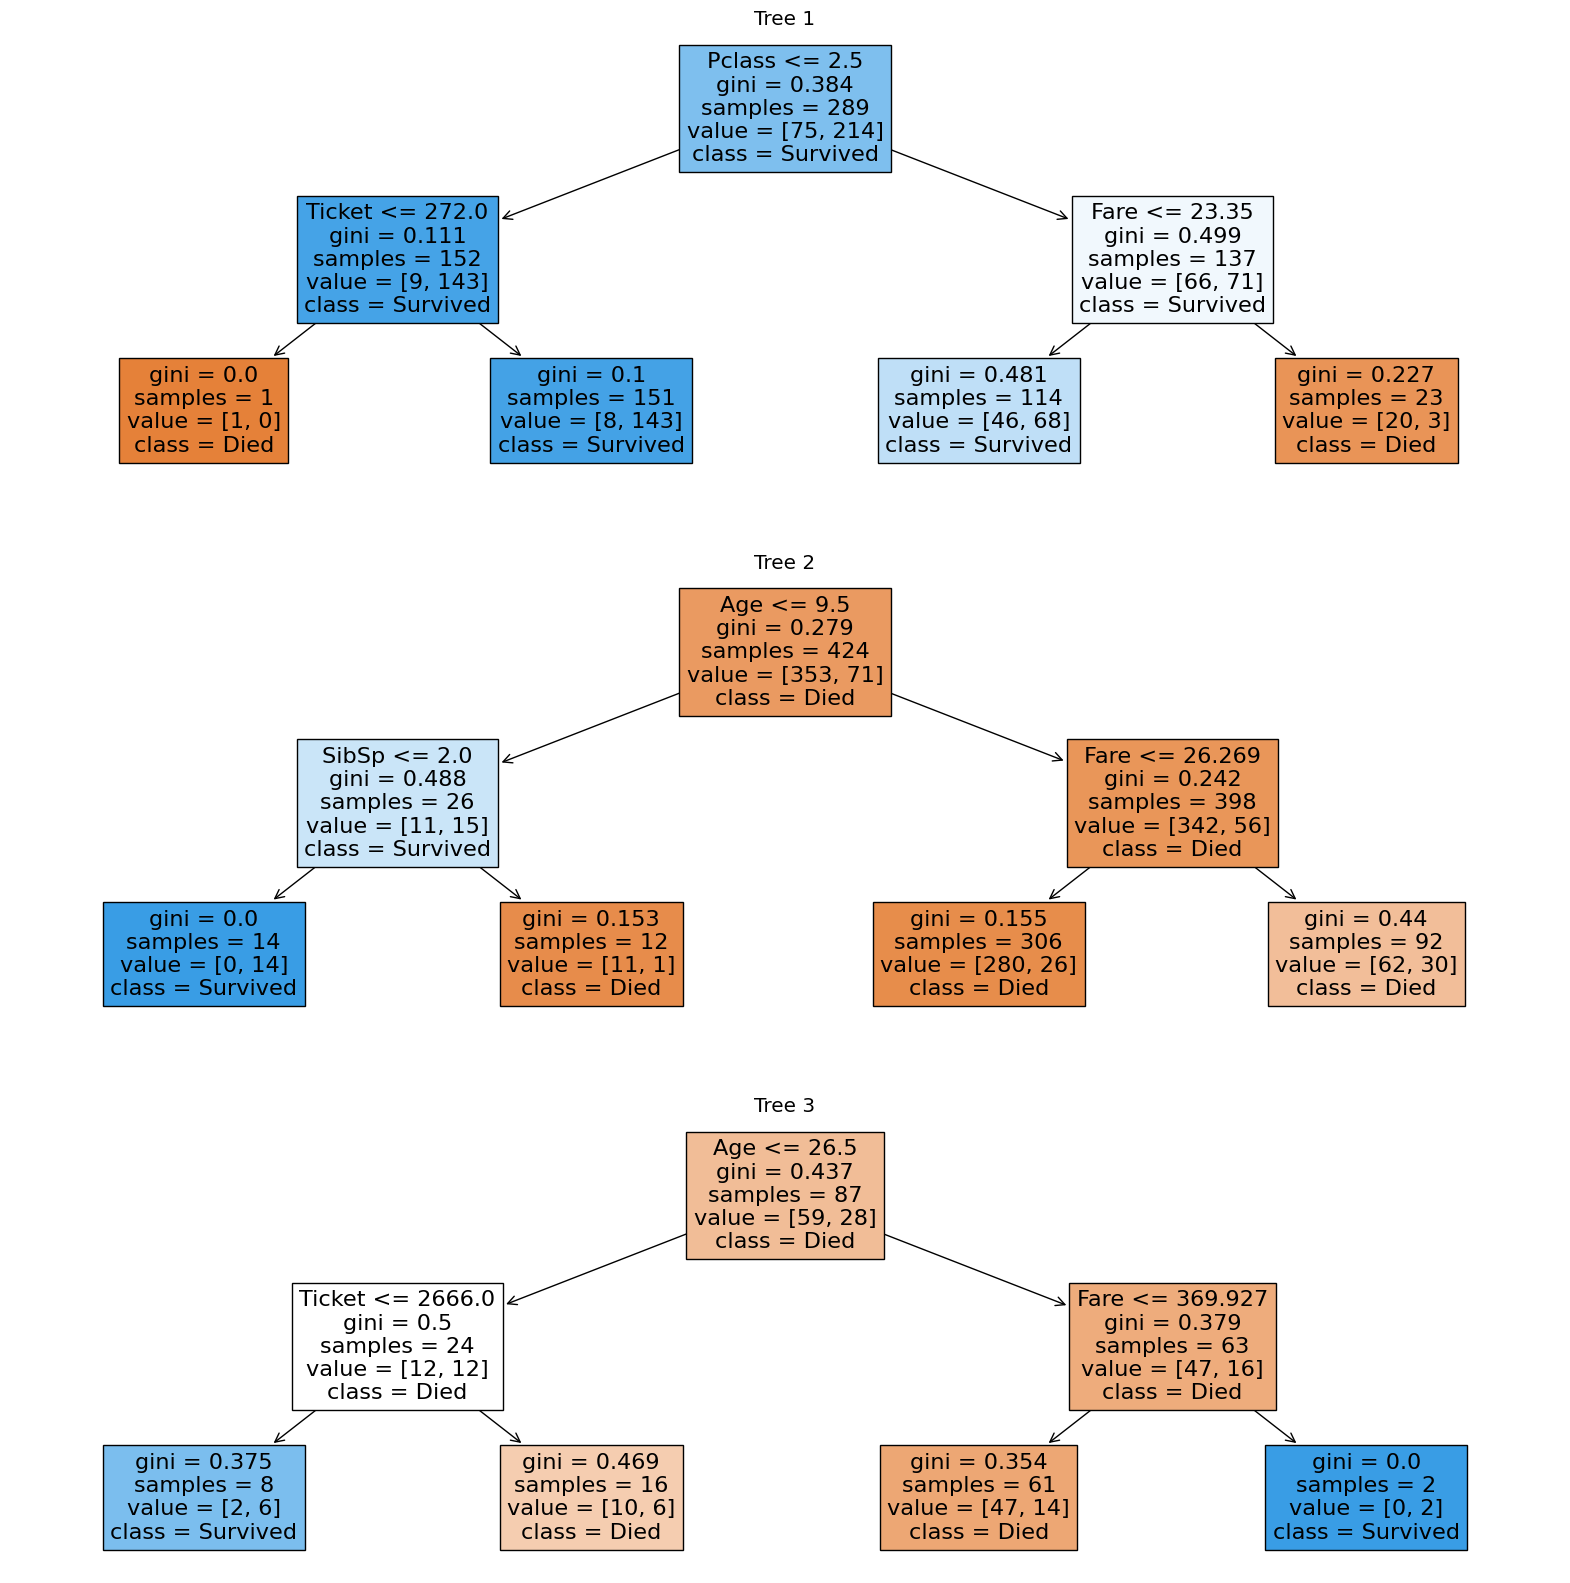

In [16]:
# Assuming 'experts' is a list of trained decision tree models from sklearn
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(len(experts), 1, figsize=(20, 20),)
for i, decision_tree in enumerate(experts):
    # Plot each decision tree
    plot_tree(decision_tree, ax=axs[i], filled=True, feature_names=X_train.columns, class_names=["Died", "Survived"])
    axs[i].set_title(f"Tree {i+1}")


### Area
we will plot the models as well as the data points onto a 2D plane
by using a dimensionality reduction technique). Be aware that the projected data is merely a estomate of the real manifold and will not be perfect.

In [17]:
# embed data into two dimensions
embedder = TSNE(n_components=2)
points = embedder.fit_transform(np.vstack([X_train, 
                                       loe.model_positions_]))

In [18]:
model_positions = points[-len(loe.pool_classifiers_):]
data_positions = points[:-len(loe.pool_classifiers_)]

In [19]:
# find out which model is responsible for which data points (dictionary model_idx -> data_indices)
model_assignments = loe.assign_data_points_to_model(X_train.to_numpy())

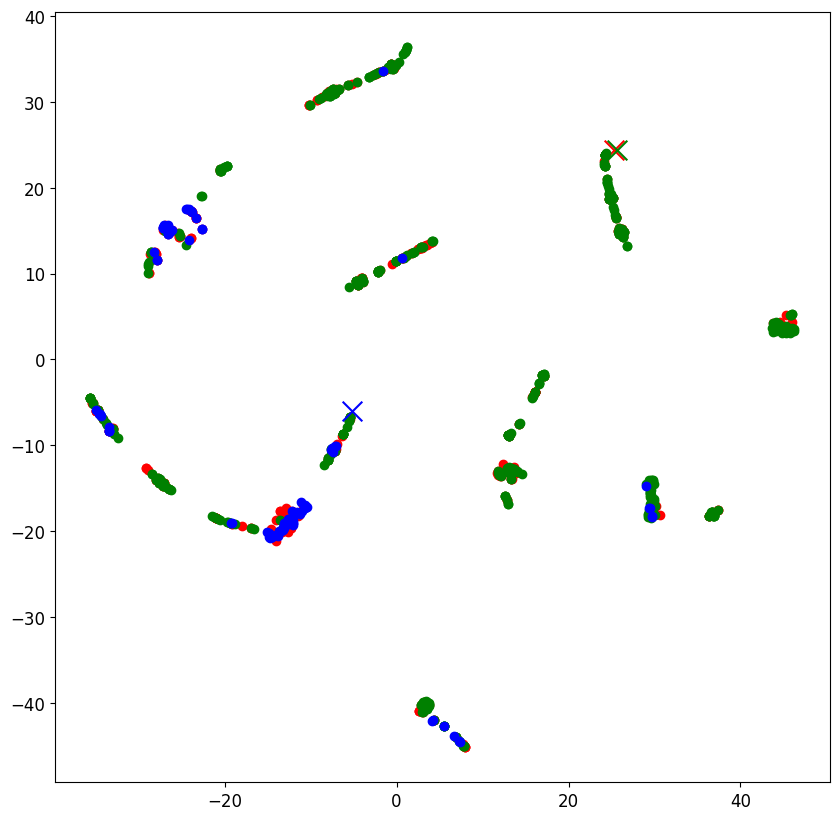

In [20]:
color_map = ['r', 'g', 'b', 'y', 'c', 'm', 'k'] 
fig = plt.figure(figsize=(10, 10))
for i in range(len(model_positions)):
    assigned_points = data_positions[model_assignments[i]]
    plt.scatter(assigned_points[:,0], assigned_points[:, 1], 
                c=color_map[i],
                label="Data for model " + str(i+ 1)) 
    
    plt.scatter(model_positions[i, 0], 
                model_positions[i, 1], c=color_map[i], label=f"Model {i+1}", s=200, marker='x')
